<a href="https://colab.research.google.com/github/drc10723/GAN_design/blob/master/GAN_implementations/Conditional_DCGAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional Deep Convolutional Generative Adversarial Networks

Implement conditional GAN as mentioned in [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784) paper.

We will use DCGAN architecture and modify for taking conditional input labels.


### Let's start by imports


In [0]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline

In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

In [3]:
# use cuda if available
DEVICE = torch.device("cuda" if torch.cuda.is_available()
                      else "cpu")
print(f"Using {DEVICE} backend")

# Training data, you can choose MNIST or Fashion MNIST
DATASET_NAME = "MNIST" #@param ["MNIST", "Fashion MNIST", ""]
# batch size for training models 
# Change multiple of 16 only, else modify below code
BATCH_SIZE = 128 #@param {type:"integer"}

Using cuda backend


## Data Loading

We will use Fashion MNIST and MNIST dataset available as part of torchvision module. 

In [0]:
%%capture
# define transform to convert images to tensors and normalize
# after normalization images will be in range [-1, 1] with mean zero.
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])
                               ])
if DATASET_NAME == "MNIST":
  # download and load training set of MNIST
  train_data = datasets.MNIST("./mnist", train=True, download=True, transform = transform)
elif DATASET_NAME == "Fashion MNIST":
  # download and load training set of Fashion MNIST
  train_data = datasets.FashionMNIST("./fmnist", train=True, download=True, transform = transform)
else:
  ValueError(f"Please select valid dataset, {DATASET_NAME} is not supported")
# create generator data loader with given batch size
dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)

In [5]:
# for checking data, lets create iterator
# We won't use this iterator for training purpose
dataiter = iter(dataloader)
images, labels = next(dataiter)
# MNIST image size is 1*28*28
img_size = images.shape[2]
print(images.shape)
# Create images grid of 16 rows, batch size need to be multiple of 16
# for batch size of 128, 128 images will be arranged in 8*16 grid 
torchvision.utils.save_image(images, f"{DATASET_NAME}_input_grid.jpg", nrow=16, padding=0, normalize=True)

torch.Size([128, 1, 28, 28])


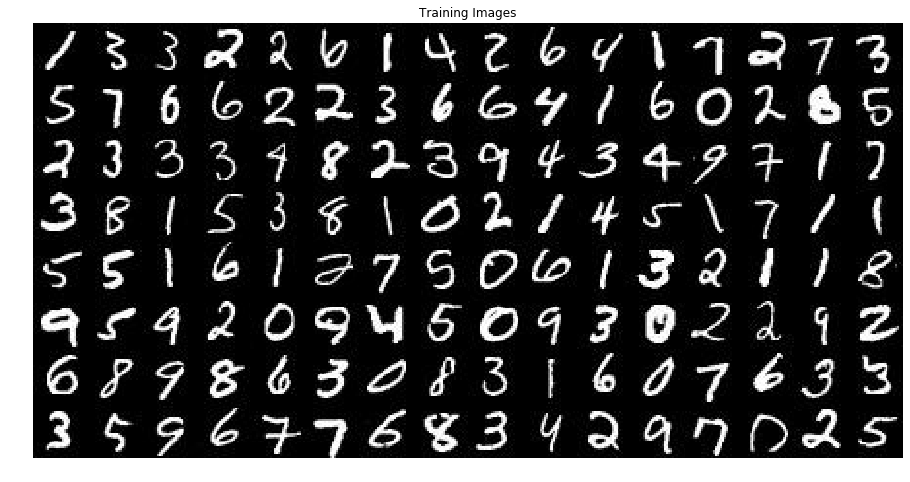

In [6]:
# Load saved training images grid and visualize using matplotlib
# Figure of size 16*(Batch_size/16)
plt.figure(figsize=(16, BATCH_SIZE/16))
plt.axis("off")
plt.title("Training Images")
# using _ for avoiding extra outputs
_ = plt.imshow(Image.open(f"{DATASET_NAME}_input_grid.jpg"))

## Discriminator Model ( D )

Discriminator is a binary classification model, which predicts if given image is generated one or taken from training data.

Discriminator model will take a image and a class label. We will reshape class label to shape (batch_size, num_labels, 28, 28) and channel corresponding to image labels will have all ones and other all zeros.

In [0]:
class Discriminator(nn.Module):
  """ D(x) """
  def __init__(self):
    # initalize super module
    super(Discriminator, self).__init__()
    
    # creating layer for image input , input size : (batch_size, 1, 28, 28)
    self.layer_x = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32,
                                           kernel_size=4, stride=2, padding=1, bias=False),
                                 # out size : (batch_size, 32, 14, 14)
                                 nn.LeakyReLU(0.2, inplace=True),
                                 # out size : (batch_size, 32, 14, 14)
                                )
                                 
    # creating layer for label input, input size : (batch_size, 10, 28, 28)
    self.layer_y = nn.Sequential(nn.Conv2d(in_channels=10, out_channels=32,
                                           kernel_size=4, stride=2, padding=1, bias=False),
                                 # out size : (batch_size, 32, 14, 14)
                                 nn.LeakyReLU(0.2, inplace=True),
                                 # out size : (batch_size, 32, 14, 14)
                                 )
    
    # layer for concat of image layer and label layer, input size : (batch_size, 64, 14, 14)
    self.layer_xy = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128,
                                            kernel_size=4, stride=2, padding=1, bias=False),
                               # out size : (batch_size, 128, 7, 7)
                               nn.BatchNorm2d(128),
                               # out size : (batch_size, 128, 7, 7)
                               nn.LeakyReLU(0.2, inplace=True),
                               # out size : (batch_size, 128, 7, 7)
                               nn.Conv2d(in_channels=128, out_channels=256,
                                         kernel_size=3, stride=2, padding=0, bias=False),
                               # out size : (batch_size, 256, 3, 3)
                               nn.BatchNorm2d(256),
                               # out size : (batch_size, 256, 3, 3)
                               nn.LeakyReLU(0.2, inplace=True),
                               # out size : (batch_size, 256, 3, 3)
                               # Notice in below layer, we are using out channels as 1, we don't need to use Linear layer
                               # Same is recommended in DCGAN paper also
                               nn.Conv2d(in_channels=256, out_channels=1,
                                         kernel_size=3, stride=1, padding=0, bias=False),
                               # out size : (batch_size, 1, 1, 1)
                               # sigmoid layer to convert in [0,1] range
                               nn.Sigmoid()
                               )
  
  def forward(self, x, y):
    # size of x : (batch_size, 1, 28, 28)
    x = self.layer_x(x)
    # size of x : (batch_size, 32, 14, 14)
    
    # size of y : (batch_size, 10, 28, 28)
    y = self.layer_y(y)
    # size of y : (batch_size, 32, 14, 14)
    
    # concat image layer and label layer output
    xy = torch.cat([x,y], dim=1)
    # size of xy : (batch_size, 64, 14, 14)
    xy = self.layer_xy(xy)
    # size of xy : (batch_size, 1, 1, 1)
    xy = xy.view(xy.shape[0], -1)
    # size of xy : (batch_size, 1)
    return xy

In [8]:
# Create the Discriminator
netD = Discriminator().to(DEVICE)
print(netD)

Discriminator(
  (layer_x): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
  )
  (layer_y): Sequential(
    (0): Conv2d(10, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
  )
  (layer_xy): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): Conv2d(256, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (7): Sigmoid()
  )
)


## Generator Model ( G )

Aim of the generator is to fool the discriminator model. Generator will take random noise ( latent vector) z and label for which image need to be generated. Label will be passed as onehot encoding.







In [0]:
class Generator(nn.Module):
  """ G(z) """
  def __init__(self, input_size=100):
    # initalize super module
    super(Generator, self).__init__()

    # noise z input layer : (batch_size, 100, 1, 1)
    self.layer_x = nn.Sequential(nn.ConvTranspose2d(in_channels=100, out_channels=128, kernel_size=3,
                                                  stride=1, padding=0, bias=False),
                                 # out size : (batch_size, 128, 3, 3)
                                 nn.BatchNorm2d(128),
                                 # out size : (batch_size, 128, 3, 3)
                                 nn.ReLU(),
                                 # out size : (batch_size, 128, 3, 3)
                                )
    
    # label input layer : (batch_size, 10, 1, 1)
    self.layer_y = nn.Sequential(nn.ConvTranspose2d(in_channels=10, out_channels=128, kernel_size=3,
                                                  stride=1, padding=0, bias=False),
                                 # out size : (batch_size, 128, 3, 3)
                                 nn.BatchNorm2d(128),
                                 # out size : (batch_size, 128, 3, 3)
                                 nn.ReLU(),
                                 # out size : (batch_size, 128, 3, 3)
                                )
    
    # noise z and label concat input layer : (batch_size, 256, 3, 3)
    self.layer_xy = nn.Sequential(nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3,
                                                  stride=2, padding=0, bias=False),
                               # out size : (batch_size, 128, 7, 7)
                               nn.BatchNorm2d(128),
                               # out size : (batch_size, 128, 7, 7)
                               nn.ReLU(),
                               # out size : (batch_size, 128, 7, 7)
                               nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4,
                                                  stride=2, padding=1, bias=False),
                               # out size : (batch_size, 64, 14, 14)
                               nn.BatchNorm2d(64),
                               # out size : (batch_size, 64, 14, 14)
                               nn.ReLU(),
                               # out size : (batch_size, 64, 14, 14)
                               nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4,
                                                  stride=2, padding=1, bias=False),
                               # out size : (batch_size, 1, 28, 28)
                               nn.Tanh())
                               # out size : (batch_size, 1, 28, 28)
    
  def forward(self, x, y):
    # x size : (batch_size, 100)
    x = x.view(x.shape[0], x.shape[1], 1, 1)
    # x size : (batch_size, 100, 1, 1)
    x = self.layer_x(x)
    # x size : (batch_size, 128, 3, 3)
    
    # y size : (batch_size, 10)
    y = y.view(y.shape[0], y.shape[1], 1, 1)
    # y size : (batch_size, 100, 1, 1)
    y = self.layer_y(y)
    # y size : (batch_size, 128, 3, 3)
    
    # concat x and y 
    xy = torch.cat([x,y], dim=1)
    # xy size : (batch_size, 256, 3, 3)
    xy = self.layer_xy(xy)
    # xy size : (batch_size, 1, 28, 28)
    return xy

In [10]:
# Create the Generator
netG = Generator().to(DEVICE)
print(netG)

Generator(
  (layer_x): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer_y): Sequential(
    (0): ConvTranspose2d(10, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer_xy): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Tanh()
  )
)


## Weight Initalization 
From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02.

In [0]:
# custom weights initialization
def weights_init(net):
    classname = net.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(net.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(net.weight.data, 1.0, 0.02)
        nn.init.constant_(net.bias.data, 0)

In [0]:
# randomly initialize all weights to mean=0, stdev=0.2.
netD.apply(weights_init)
netG.apply(weights_init)

## Model Training



*   Value of beta1 hyperparameter in Adam optimizer has huge impact on stability of generator and DCGAN paper recommend 0.5 value.
*   Recommended learning rate for Adam is 0.0002.

In [0]:
# number of training epochs
NUM_EPOCH = 20 #@param {type:"integer"}
# size of latent vector z
size_z = 100
# number of discriminator steps for each generator step
Ksteps = 1 #@param {type:"integer"}
# learning rate of adam
# DCGAN recommend 0.0002 lr
Adam_lr = 0.0002 #@param {type:"number"}
# DCGAN recommend 0.5
Adam_beta1 = 0.5 #@param {type:"number"}

In [0]:
# We calculate Binary cross entropy loss
criterion = nn.BCELoss()
# Adam optimizer for generator 
optimizerG = torch.optim.Adam(netG.parameters(), lr=Adam_lr, betas=(Adam_beta1, 0.999))
# Adam optimizer for discriminator 
optimizerD = torch.optim.Adam(netD.parameters(), lr=Adam_lr, betas=(Adam_beta1, 0.999))

In [0]:
# labels for training images x for Discriminator training
labels_real = torch.ones((BATCH_SIZE, 1)).to(DEVICE)
# labels for generated images G(z) for Discriminator training
labels_fake = torch.zeros((BATCH_SIZE, 1)).to(DEVICE)
# Fix noise for testing generator and visualization
z_test = torch.randn(100, size_z).to(DEVICE)

In [0]:
# convert labels to onehot encoding
onehot = torch.zeros(10, 10).scatter_(1, torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).view(10,1), 1)
# reshape labels to image size, with number of labels as channel
fill = torch.zeros([10, 10, img_size, img_size])
#channel corresponding to label will be set one and all other zeros
for i in range(10):
    fill[i, i, :, :] = 1
# create labels for testing generator
test_y = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]*10).type(torch.LongTensor)
# convert to one hot encoding
test_Gy = onehot[test_y].to(DEVICE)

In [0]:
# List of values, which will be used for plotting purpose
D_losses = []
G_losses = []
Dx_values = []
DGz_values = []

# number of training steps done on discriminator 
step = 0
for epoch in range(NUM_EPOCH):
  epoch_D_losses = []
  epoch_G_losses = []
  epoch_Dx = []
  epoch_DGz = []
  # iterate through data loader generator object
  for images, y_labels in dataloader:
    step += 1
    ############################
    # Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    # images will be send to gpu, if cuda available
    x = images.to(DEVICE)
    # preprocess labels for feeding as y input
    # D_y shape will be (batch_size, 10, 28, 28)
    D_y = fill[y_labels].to(DEVICE)
    # forward pass D(x)
    x_preds = netD(x, D_y)
    # calculate loss log(D(x))
    D_x_loss = criterion(x_preds, labels_real)
    
    # create latent vector z from normal distribution 
    z = torch.randn(BATCH_SIZE, size_z).to(DEVICE)
    # create random y labels for generator
    y_gen = (torch.rand(BATCH_SIZE, 1)*10).type(torch.LongTensor).squeeze()
    # convert genarator labels to onehot
    G_y = onehot[y_gen].to(DEVICE)
    # preprocess labels for feeding as y input in D
    # DG_y shape will be (batch_size, 10, 28, 28)
    DG_y = fill[y_gen].to(DEVICE)
    
    # generate image
    fake_image = netG(z, G_y)
    # calculate D(G(z)), fake or not
    z_preds = netD(fake_image.detach(), DG_y)
    # loss log(1 - D(G(z)))
    D_z_loss = criterion(z_preds, labels_fake)
    
    # total loss = log(D(x)) + log(1 - D(G(z)))
    D_loss = D_x_loss + D_z_loss
    
    # save values for plots
    epoch_D_losses.append(D_loss.item())
    epoch_Dx.append(x_preds.mean().item())
    
    # zero accumalted grads
    netD.zero_grad()
    # do backward pass
    D_loss.backward()
    # update discriminator model
    optimizerD.step()
    
    ############################
    # Update G network: maximize log(D(G(z)))
    ###########################
        
    # if Ksteps of Discriminator training are done, update generator
    if step % Ksteps == 0:
      # As we done one step of discriminator, again calculate D(G(z))
      z_out = netD(fake_image, DG_y)
      # loss log(D(G(z)))
      G_loss = criterion(z_out, labels_real)
      # save values for plots
      epoch_DGz.append(z_out.mean().item())
      epoch_G_losses.append(G_loss)
      
      # zero accumalted grads
      netG.zero_grad()
      # do backward pass
      G_loss.backward()
      # update generator model
      optimizerG.step()
  else:
    # calculate average value for one epoch
    D_losses.append(sum(epoch_D_losses)/len(epoch_D_losses))
    G_losses.append(sum(epoch_G_losses)/len(epoch_G_losses))
    Dx_values.append(sum(epoch_Dx)/len(epoch_Dx))
    DGz_values.append(sum(epoch_DGz)/len(epoch_DGz))
    
    print(f" Epoch {epoch+1}/{NUM_EPOCH} Discriminator Loss {D_losses[-1]:.3f} Generator Loss {G_losses[-1]:.3f}"
         + f" D(x) {Dx_values[-1]:.3f} D(G(x)) {DGz_values[-1]:.3f}")
    
    # Generating images after each epoch and saving
    # set generator to evaluation mode
    netG.eval()
    with torch.no_grad():
      # forward pass of G and generated image
      fake_test = netG(z_test, test_Gy).cpu()
      # save images in grid of 10 * 10
      torchvision.utils.save_image(fake_test, f"{DATASET_NAME}_epoch_{epoch+1}.jpg", nrow=10, padding=0, normalize=True)
    # set generator to training mode
    netG.train()

## Results

After 20 epoch training, we are able to generate quite good images.

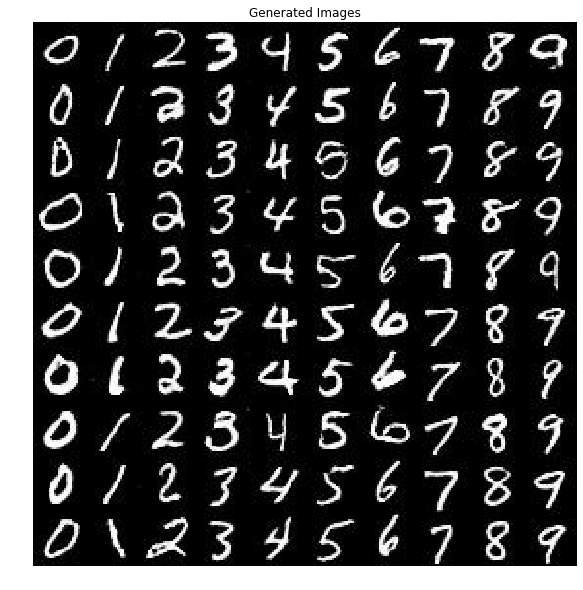

In [18]:
# Load saved generated images grid and visualize using matplotlib
# Figure of size 10*10
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Generated Images")
# using _ for avoiding extra outputs
_ = plt.imshow(Image.open(f"{DATASET_NAME}_epoch_{NUM_EPOCH}.jpg"))

### Animation of generated images after each epoch

In [0]:
%%capture
# using capture magic for avoiding extra outputs
fig = plt.figure(figsize=(10,10))
plt.axis("off")
# load all images
ims = [[plt.imshow(Image.open(f"{DATASET_NAME}_epoch_{i+1}.jpg"), animated=True)] for i in range(NUM_EPOCH)]
# create animation 
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

In [0]:
# showing animation using Ipython HTML
HTML(ani.to_jshtml())

In [0]:
ani.save('FMNIST_animation.gif', writer='imagemagick', fps=5)



### Plot for Discriminator and Generator loss over the epochs

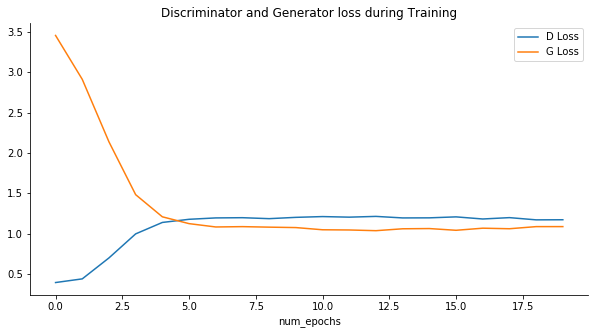

In [22]:
plt.figure(figsize=(10,5))
plt.title("Discriminator and Generator loss during Training")
# plot Discriminator and generator loss
plt.plot(D_losses,label="D Loss")
plt.plot(G_losses,label="G Loss")
# get plot axis
ax = plt.gca()
# remove right and top spine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# add labels and create legend
plt.xlabel("num_epochs")
plt.legend()
plt.show()